Stwórz funkcję o nazwie 'Bernoullie', przyjmującą jeden parameter 'p', floata z przedziału od 0 do 1.
Funkcja ma realziwoać rozkład zero-jedynkowy, czyli zwracać wartość 1 z prawdopodbieństwem 'p', a 0 z prawdopodobieństwem '1-p'.

In [4]:
import numpy as np
import random
def Bernoullie(p):
    if not 0 <= p <= 1:
        raise ValueError("Parameter 'p' must be a float between 0 and 1.")
    return 1 if random.random() < p else 0

Sprawdź czy funkcja działa zgodnie z oczekiwaniami.

In [7]:
ile = 5000
sum([Bernoullie(0.2) for i in range(ile)])/ile

0.1978

Stwórz klasę RBM, która ma implementować Ograniczoną Maszynę Boltzmanna. Konstuktor powineine przyjąć dwa parametry 'no_v' i 'no_h' określające odpowiednio liczbę neuronów w warstwie widocznej i ukrytej. Zaininciuj odpowiednie wagi.

In [8]:
class RBM:
    def __init__(self, no_v, no_h):
        self.wagi = np.random.random((no_v, no_h))
        self.b = np.random.random(no_v)
        self.c = np.random.random(no_h)

Napisz metodę aktywacji warstwy ukrytej 'activate_hidden_layer'. Metoda na wejście ma przyjmować wartości tablicę warstwy widocznej 'v'. Meotda ma zwracać tablicę realizacji aktywacji neuronów warstwy ukrytej oraz tablicę prawdopodobieństw tej aktywacji.

In [9]:
class RBM:
    def __init__(self, no_v, no_h):
        self.wagi = np.random.random((no_v, no_h))
        self.b = np.random.random(no_v)
        self.c = np.random.random(no_h)
        
    def activate_hidden_layer(self, v):
    
        probabilities = 1 / (1 + np.exp(-np.dot(v, self.wagi) - self.c))
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        
        return activations, probabilities

Napisz analogiczną metodę do aktywacji warstwy widocznej 'activate_visible_layer'.

In [16]:

def sigmoid(s):
    return 1 / (1 + np.exp(-s))

class RBM:
    def __init__(self, no_v, no_h):
        self.wagi = np.random.random((no_v, no_h))
        self.b = np.random.random(no_v)
        self.c = np.random.random(no_h)
    
    def Bernoullie(self, p):
        return 1 if np.random.random() < p else 0
    
    def activate_hidden_layer(self, v):
        probabilities = 1 / (1 + np.exp(-np.dot(v, self.wagi) - self.c))
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        
        return activations, probabilities

    def activate_visible_layer(self, h):
        probabilities = 1 / (1 + np.exp(-np.dot(h, self.wagi.T) - self.b))
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        return activations, probabilities

Sprawdź czy warstwy działają tak jak tego oczekujemy.

In [18]:
model = RBM(3,2)
model.activate_hidden_layer([1,1,1])

(array([1, 1]), array([0.79411686, 0.79449104]))

Napisz metodę rezalizującą metodę contrastive divergence. Metoda ma jako parametry przyjmować zbiór elementów (mini-batch) oznaczony X oraz liczbę iteracji algorytmu (k). Metoda ma zwracać 6 wartości. Mają to być odpowiednio dla  tablicy wag, biasu warstwy widocznej i biasu warstwy ukrytej wartości 'E_data' oraz 'E_recon'  

In [ ]:
import numpy as np

class RBM:
    def __init__(self, no_v, no_h):
        self.wagi = np.random.random((no_v, no_h))
        self.b = np.random.random(no_v)
        self.c = np.random.random(no_h)
        
    def Bernoullie(self, p):
        return 1 if np.random.random() < p else 0

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))

    def activate_hidden_layer(self, v):
        probabilities = self.sigmoid(np.dot(v, self.wagi) + self.c)
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        return activations, probabilities

    def activate_visible_layer(self, h):
        probabilities = self.sigmoid(np.dot(h, self.wagi.T) + self.b)
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        return activations, probabilities
    
    def CD(self, X, k=1):
        E_data = np.zeros_like(self.wagi)
        E_recon = np.zeros_like(self.wagi)
        E_bv_data = np.zeros_like(self.b)
        E_bv_recon = np.zeros_like(self.b)
        E_bh_data = np.zeros_like(self.c)
        E_bh_recon = np.zeros_like(self.c)
        
        for v in X:
            # Positive phase
            h0, ph0 = self.activate_hidden_layer(v)
            E_data += np.outer(v, ph0)
            E_bv_data += v
            E_bh_data += ph0
            
            # Gibbs sampling
            vk = v
            for _ in range(k):
                hk, _ = self.activate_hidden_layer(vk)
                vk, _ = self.activate_visible_layer(hk)
            
            # Negative phase
            hk, phk = self.activate_hidden_layer(vk)
            E_recon += np.outer(vk, phk)
            E_bv_recon += vk
            E_bh_recon += phk
        
        # Normalize
        n_samples = len(X)
        E_data /= n_samples
        E_recon /= n_samples
        E_bv_data /= n_samples
        E_bv_recon /= n_samples
        E_bh_data /= n_samples
        E_bh_recon /= n_samples
        
        return E_data, E_recon, E_bv_data, E_bv_recon, E_bh_data, E_bh_recon

Napisz metodę fit realziujacą uczenie metodą spadku gradientu metodą mini-batchową, gdzie gradienty są liczone metodą contrastive divergency (CD). Metoda ma przyjmować parametry: zbiór uczący (X), liczba epok (epochs), wielkość mini-batcha (bs), liczba iteracji dla CD (k) oraz współczynnik uczenia (lr).

In [20]:
import numpy as np

class RBM:
    def __init__(self, no_v, no_h):
        self.wagi = np.random.random((no_v, no_h))
        self.b = np.random.random(no_v)
        self.c = np.random.random(no_h)
        
    def Bernoullie(self, p):
        return 1 if np.random.random() < p else 0

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))

    def activate_hidden_layer(self, v):
        probabilities = self.sigmoid(np.dot(v, self.wagi) + self.c)
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        return activations, probabilities

    def activate_visible_layer(self, h):
        probabilities = self.sigmoid(np.dot(h, self.wagi.T) + self.b)
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        return activations, probabilities
    
    def CD(self, X, k=1):
        E_data = np.zeros_like(self.wagi)
        E_recon = np.zeros_like(self.wagi)
        E_bv_data = np.zeros_like(self.b)
        E_bv_recon = np.zeros_like(self.b)
        E_bh_data = np.zeros_like(self.c)
        E_bh_recon = np.zeros_like(self.c)
        
        for v in X:
            h0, ph0 = self.activate_hidden_layer(v)
            E_data += np.outer(v, ph0)
            E_bv_data += v
            E_bh_data += ph0
            
            vk = v
            for _ in range(k):
                hk, _ = self.activate_hidden_layer(vk)
                vk, _ = self.activate_visible_layer(hk)
            
            hk, phk = self.activate_hidden_layer(vk)
            E_recon += np.outer(vk, phk)
            E_bv_recon += vk
            E_bh_recon += phk
        
        n_samples = len(X)
        E_data /= n_samples
        E_recon /= n_samples
        E_bv_data /= n_samples
        E_bv_recon /= n_samples
        E_bh_data /= n_samples
        E_bh_recon /= n_samples
        
        return E_data, E_recon, E_bv_data, E_bv_recon, E_bh_data, E_bh_recon

    def fit(self, X, epochs=10, bs=10, k=1, lr=0.01):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            np.random.shuffle(X)
            for i in range(0, n_samples, bs):
                X_batch = X[i:i+bs]
                E_data, E_recon, E_bv_data, E_bv_recon, E_bh_data, E_bh_recon = self.CD(X_batch, k)
                
                self.wagi += lr * (E_data - E_recon)
                self.b += lr * (E_bv_data - E_bv_recon)
                self.c += lr * (E_bh_data - E_bh_recon)

Napisz metodę obliczającą błąd rekonstrukcji 'recreate_error'. Metoda ma przyjmować jako parametr tablicę danych. Dla kolejnych elementów z tablicy ma być obliczana ich ukryta reprezentacja, a następnie na tej podstawie ma być ten element odtworzony przez sieć. 
Metoda ma zwracać błąd absolutny odtworzenia.

In [21]:
import numpy as np

class RBM:
    def __init__(self, no_v, no_h):
        self.wagi = np.random.random((no_v, no_h))
        self.b = np.random.random(no_v)
        self.c = np.random.random(no_h)
        
    def Bernoullie(self, p):
        return 1 if np.random.random() < p else 0

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))

    def activate_hidden_layer(self, v):
        probabilities = self.sigmoid(np.dot(v, self.wagi) + self.c)
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        return activations, probabilities

    def activate_visible_layer(self, h):
        probabilities = self.sigmoid(np.dot(h, self.wagi.T) + self.b)
        activations = np.array([self.Bernoullie(p) for p in probabilities])
        return activations, probabilities
    
    def CD(self, X, k=1):
        E_data = np.zeros_like(self.wagi)
        E_recon = np.zeros_like(self.wagi)
        E_bv_data = np.zeros_like(self.b)
        E_bv_recon = np.zeros_like(self.b)
        E_bh_data = np.zeros_like(self.c)
        E_bh_recon = np.zeros_like(self.c)
        
        for v in X:
            h0, ph0 = self.activate_hidden_layer(v)
            E_data += np.outer(v, ph0)
            E_bv_data += v
            E_bh_data += ph0
            
            vk = v
            for _ in range(k):
                hk, _ = self.activate_hidden_layer(vk)
                vk, _ = self.activate_visible_layer(hk)
            
            hk, phk = self.activate_hidden_layer(vk)
            E_recon += np.outer(vk, phk)
            E_bv_recon += vk
            E_bh_recon += phk
        
        n_samples = len(X)
        E_data /= n_samples
        E_recon /= n_samples
        E_bv_data /= n_samples
        E_bv_recon /= n_samples
        E_bh_data /= n_samples
        E_bh_recon /= n_samples
        
        return E_data, E_recon, E_bv_data, E_bv_recon, E_bh_data, E_bh_recon

    def fit(self, X, epochs=10, bs=10, k=1, lr=0.01):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            np.random.shuffle(X)
            for i in range(0, n_samples, bs):
                X_batch = X[i:i+bs]
                E_data, E_recon, E_bv_data, E_bv_recon, E_bh_data, E_bh_recon = self.CD(X_batch, k)
                
                self.wagi += lr * (E_data - E_recon)
                self.b += lr * (E_bv_data - E_bv_recon)
                self.c += lr * (E_bh_data - E_bh_recon)
    
    def recreate_error(self, X):
        total_error = 0
        for v in X:
            _, ph = self.activate_hidden_layer(v)
            _, pv = self.activate_visible_layer(ph)
            total_error += np.sum(np.abs(v - pv))
        return total_error / len(X)

Wczytaj dane ze zbioru MNIST. Możesz to zrobić używając polecenia:

from keras.datasets import mnist

Następnie przetrasformuj dane tak, aby piksele były zakodowane jako wartości 0 lub 1 (np. użyj testu piksel>128). 
Wyświetl kilka obrazów.

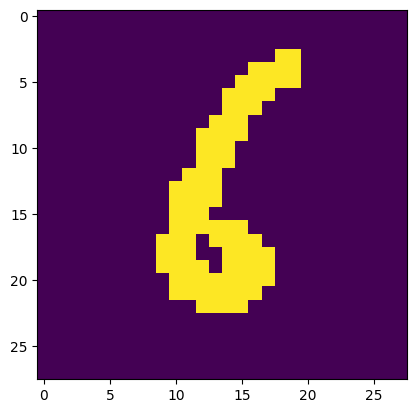

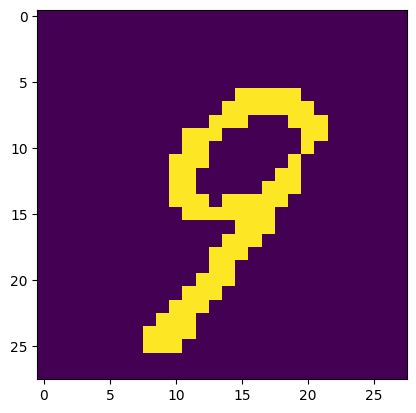

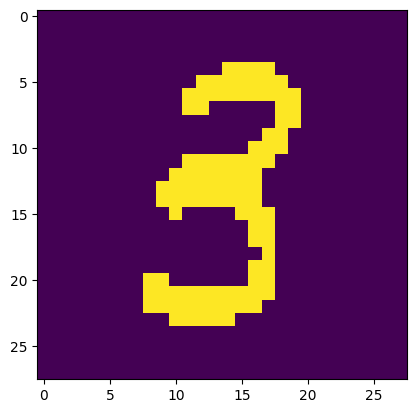

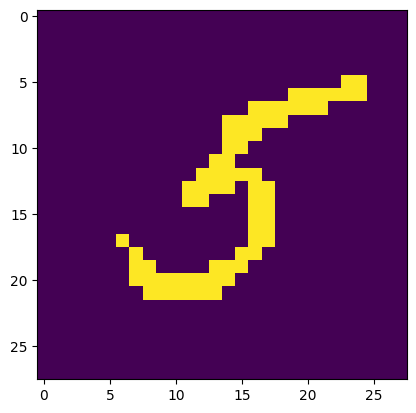

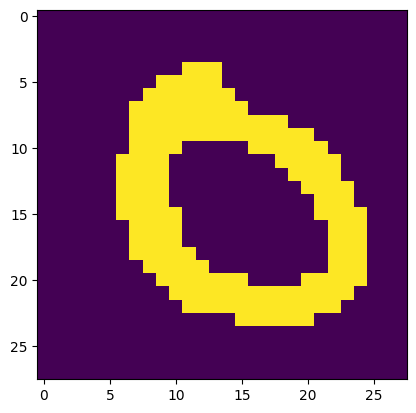

In [22]:
from keras.datasets import mnist

(X, Y), (Xt, Yt) = mnist.load_data()

X = X.reshape((X.shape[0], 28*28))
X = np.asarray(X, dtype=float)
Xt = Xt.reshape((Xt.shape[0], 28*28))
Xt = np.asarray(Xt, dtype=float)
X /= 255
Xt /= 255
X[X > 0.5] = 1
X[X <= 0.5] = 0

import matplotlib.pyplot as plt
for i in range(5):
    j = np.random.randint(len(X))
    plt.imshow(X[j].reshape((28,28)))
    plt.show()


Utwórz model i naucz go na przygotowanych danych

In [ ]:
model = RBM(28*28, 100)
model.fit(X, 10, lr=0.01)

Wyświetl koło siebie kilka przykładów obrazów ze zbioru danych i odtworzonych.

In [ ]:
j = 3
k=0
for i in np.random.randint(0,len(X), j):
  plt.subplot(j, 2, k*2+1)
  x, _ = model.activate_hidden(X[i])
  x, _ = model.activate_visible(x)
  x = x.reshape((28, 28))
  plt.imshow(x)
  plt.xticks([])
  plt.yticks([])
  plt.subplot(j, 2, k*2+2)
  plt.imshow(X[i].reshape((28,28)))
  k += 1
  plt.xticks([])
  plt.yticks([])